Libretas:

Martin Acuña LU: 596/21

Facundo Alvarez Motta LU: 889/21

Manuel Horn LU: 321/21

# Práctica 4: Redes neuronales convolucionales para clasificación de imágenes

En esta práctica, vamos a utilizar modelos profundos para clasificar dígitos manuscritos, de forma similar al práctico 1. En este caso, utilizaremos el dataset MNIST donde los dígitos poseen un tamaño de 28x28 (en lugar de 8x8 como en dicho práctico).

Para eso, comenzamos por cargar y visualizar el dataset:

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 11162610.27it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 337492.08it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:02<00:00, 669592.56it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 8902116.25it/s]
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



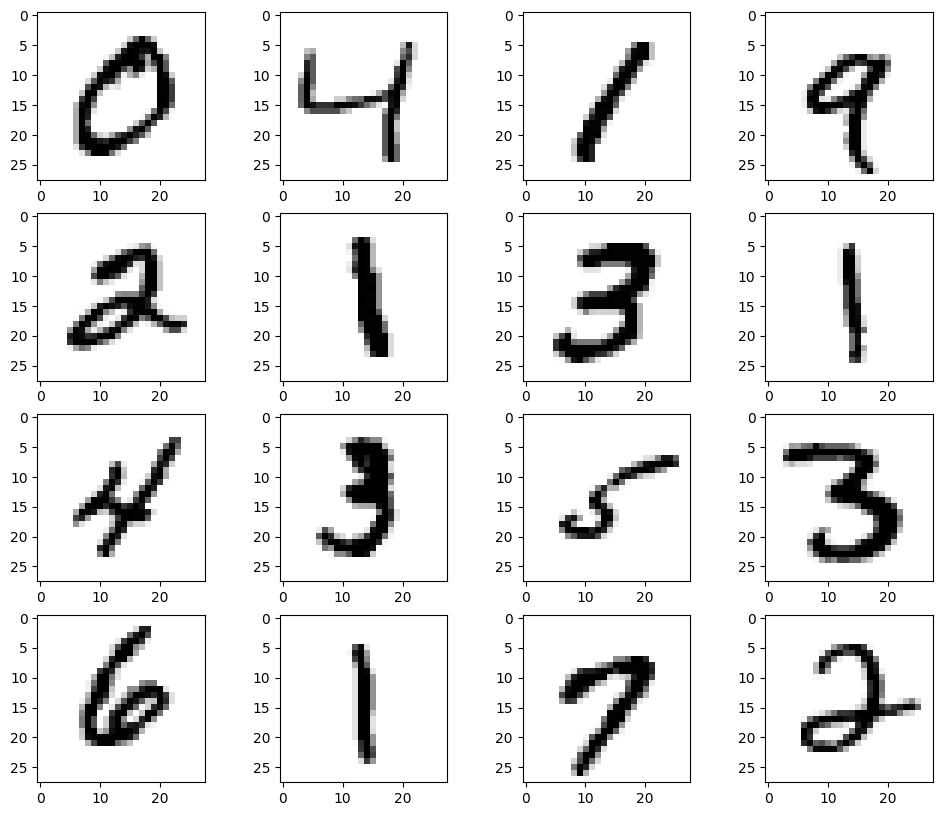

In [1]:
import torchvision
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = [12, 10]

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=torchvision.transforms.ToTensor())


for i in range(1,17):
    plt.subplot(4,4,i)
    plt.imshow(mnist_train.train_data[i,:,:], cmap=plt.get_cmap('gray_r'))


In [ ]:
mnist_train.data.shape #60000 imagenes de 28x28

torch.Size([60000, 28, 28])

# Perceptrón multicapa

Primero, vamos a adaptar el perceptrón mutlicapa implementado en la práctica anterior, para que pueda clasificar imágenes de 28 x 28 en 10 categorías diferentes. Para ello, deberemos realizar algunos cambios:

* Antes de procesar la imagen, deberemos reformatearla para que pase de ser una imagen de 28 x 28, a un vector de 784 componetes. Para ello, utilziaremos el método `view` de los tensores de Pytorch.

* Utilizaremos un perceptrón con 15 neuronas en las capas intermedias.

* La última capa deberá tener 10 neuronas (en lugar de 1 sola como tenia el perceptrón multicapa que utilizamos para hacer regresión).

* Deberemos cambiar la función de pérdida. En este caso, utilizaremos Entropía Cruzada (`torch.nn.CrossEntropyLoss`)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
class NetMLP(torch.nn.Module):
    def __init__(self, input_features, size_hidden, n_output):
        super(NetMLP, self).__init__()
        self.flatten = torch.nn.Flatten()
        self.hidden1 = torch.nn.Linear(input_features, size_hidden)
        self.hidden2 = torch.nn.Linear(size_hidden, size_hidden)
        self.out = torch.nn.Linear(size_hidden, n_output)

    def forward(self, x):
        # Flatten the input tensor
        x = self.flatten(x)
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = self.out(x)
        return x


Epoch 0, loss = 0.734614
Epoch 1, loss = 0.524913
Epoch 2, loss = 0.278885
Epoch 3, loss = 0.263057
Epoch 4, loss = 0.199306


Text(0.5, 1.0, 'Función de pérdida durante el entrenamiento')

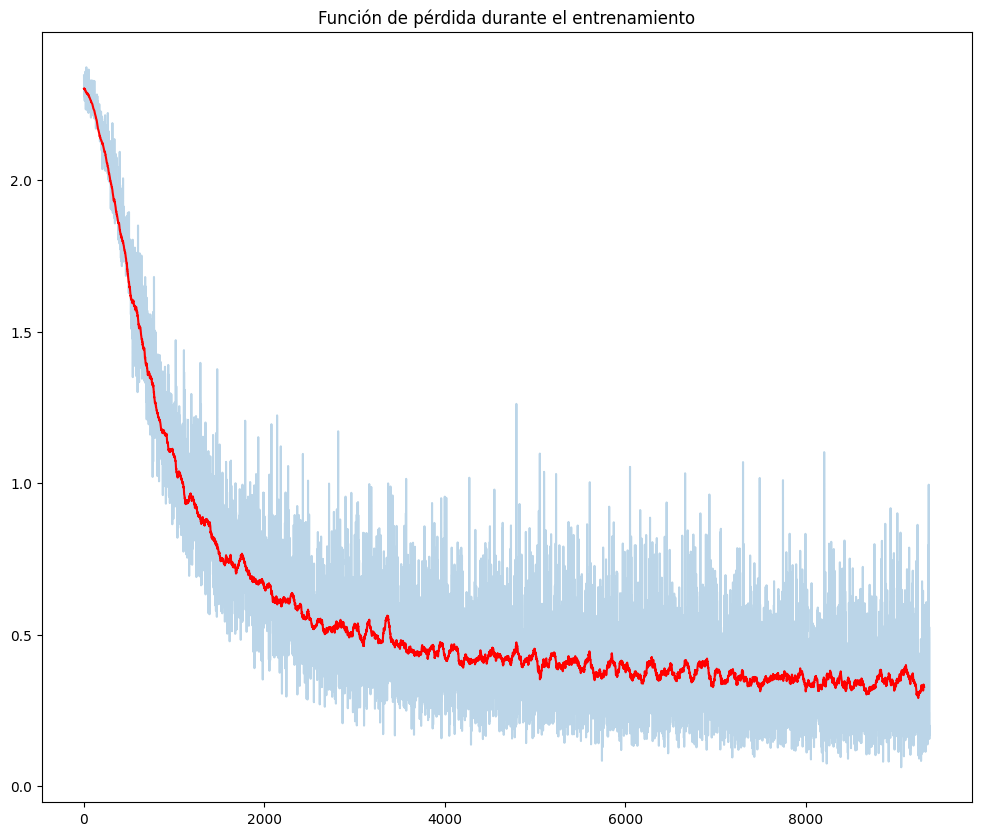

In [ ]:
# Definimos el modelo del perceptrón
input_features = 28*28
hidden_neurons = 15
num_outputs = 10

# Tamaño del batch de entrenamiento
batch_size = 50

# Tasa de aprendizaje inicial para el gradiente descendente
learning_rate = 0.0001

# Dispositivo en que se ejecturá el modelo: 'cuda:0' para GPU y 'cpu' para CPU
device = torch.device('cuda:0')

net = NetMLP(input_features, hidden_neurons, num_outputs)
net.to(device)

# Construimos el optimizador, y le indicamos que los parámetros a optimizar
# son los del modelo definido: net.parameters()

optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# Definimos también la función de pérdida a utilizar
criterion = torch.nn.CrossEntropyLoss()

# Creamos un loader iterable indicandole que debe leer los datos a partir de
# del dataset creado en el paso anterior. Este objeto puede ser iterado
# y nos devuelve de a un batch (x, y).
loader = DataLoader(dataset=mnist_train, batch_size=32, shuffle=True)

# Número de épocas
num_epochs = 5

# Lista en la que iremos guardando el valor de la función de pérdida en cada
# etapa de entrenamiento
loss_list = []

# Bucle de entrenamiento
for i in range(num_epochs):

    # Itero sobre todos los batches del dataset
    for x, y in loader:
        # Seteo en cero los gradientes de los parámetros a optimizar
        optimizer.zero_grad()

        # Movemos los tensores a memoria de GPU
        x = x.to(device)
        y = y.to(device)

        # Realizo la pasada forward por la red
        loss = criterion(net(x), y)

        # Realizo la pasada backward por la red
        loss.backward()

        # Actualizo los pesos de la red con el optimizador
        optimizer.step()

        # Me guardo el valor actual de la función de pérdida para luego graficarlo
        loss_list.append(loss.data.item())

    # Muestro el valor de la función de pérdida cada 100 iteraciones
    #if i > 0 and i % 100 == 0:
    print('Epoch %d, loss = %g' % (i, loss))

# Muestro la lista que contiene los valores de la función de pérdida
# y una versión suavizada (rojo) para observar la tendencia
plt.figure()
loss_np_array = np.array(loss_list)
plt.plot(loss_np_array, alpha = 0.3)
N = 60
running_avg_loss = np.convolve(loss_np_array, np.ones((N,))/N, mode='valid')
plt.plot(running_avg_loss, color='red')
plt.title("Función de pérdida durante el entrenamiento")


### Guardamos el modelo para poder reutilizarlo

In [ ]:
torch.save(net.state_dict(), "./mlp20.pth")

#### Cargamos el modelo y visualizamos los resultados en los datos de test

Para ello, utilizaremos los métodos `classification_report` y `confusion_matrix` de scikitlearn.

In [ ]:
# Cargo el modelo guardado (si el modelo se encuentra en memoria, este paso no es necesario)
input_features = 28*28
hidden_neurons = 15
num_outputs = 10
net = NetMLP(input_features,hidden_neurons,num_outputs)
net.load_state_dict(torch.load("./mlp20.pth"))
net.to(device)

NetMLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (hidden1): Linear(in_features=784, out_features=15, bias=True)
  (hidden2): Linear(in_features=15, out_features=15, bias=True)
  (out): Linear(in_features=15, out_features=10, bias=True)
)

              precision    recall  f1-score   support

           0       0.92      0.97      0.95       980
           1       0.97      0.98      0.98      1135
           2       0.90      0.89      0.89      1032
           3       0.90      0.90      0.90      1010
           4       0.91      0.91      0.91       982
           5       0.89      0.84      0.86       892
           6       0.93      0.94      0.93       958
           7       0.91      0.90      0.91      1028
           8       0.88      0.85      0.86       974
           9       0.86      0.89      0.88      1009

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



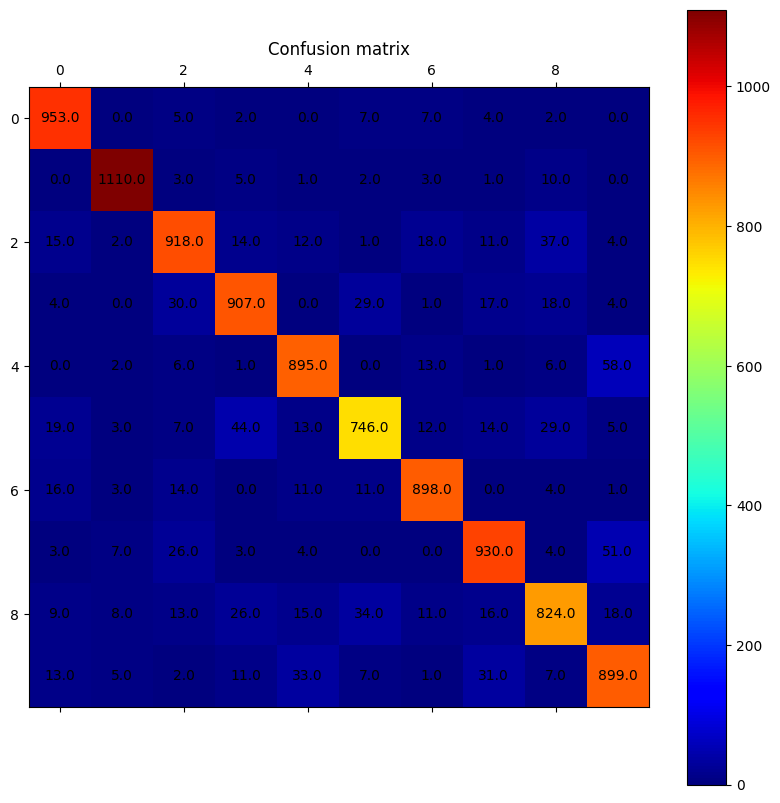

In [ ]:
def showTestResults(model):
  plt.rcParams['figure.figsize'] = [12, 10]
  from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay

  # Genero un data loader para leer los datos de test
  loader_test = DataLoader(dataset=mnist_test, batch_size=10000, shuffle=False)
  x_test = list(loader_test)[0][0]
  y_test = list(loader_test)[0][1]

  # Muevo los tensores a la GPU
  x_test = x_test.to(device)

  # Realizo las predicciones del modelo
  pred = model(x_test)

  # Extraigo el índice de la predicción con mayor valor para decidir la clase asignada
  pred_y = torch.max(pred.to("cpu"), 1)[1].data.numpy()

  # Imprimo el reporte de clasificación (accuracy, etc)
  print(classification_report(y_test, pred_y))

  # Computo la matriz de confusión y la muestro
  conf_mat = confusion_matrix(y_test, pred_y)
  plt.matshow(conf_mat, cmap='jet')

  for (i, j), z in np.ndenumerate(conf_mat):
      plt.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

  plt.title("Confusion matrix")
  plt.colorbar()

showTestResults(net)

# Red Neuronal Convolucional

También definiremos un modelo NetCNN que implemente una red neuronal convolucional, el cual seguirá la siguiente estructura:
* Capa convolucional (`nn.Conv2D`) (6 feature maps de salida) + ReLU
* Max pooling 2 x 2 (`F.max_pool2d`)
* Capa convolucional (`nn.Conv2D`) (16 feature maps de salida) + ReLU
* Max pooling 2 x 2 (`F.max_pool2d`)
* Capa totalmente conectada (`nn.Linear`) (120 neuronas) + ReLU
* Capa totalmente conectada (`nn.Linear`) (84 neuronas) + ReLU
* Capa de salida (`nn.Linear`) (10 neuronas)

Notar que utilizaremos la función `CrossEntropyLoss` para entrenar el modelo. Recordar que dados:
* F: tamaño del filtro
* W: Tamaño del feature map de entrada
* P: Padding
* S: Stride

El tamaño de la salida es $O = \frac{(W - F + 2P)}{S} + 1$


In [ ]:
class NetCNN(nn.Module):

    def __init__(self):
        super(NetCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # Al pasar de capa convolucional a capa totalmente conectada, tenemos
        # que reformatear la salida para que se transforme en un vector unidimensional
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Epoch 0, loss = 0.414539
Epoch 1, loss = 0.117242
Epoch 2, loss = 0.119165
Epoch 3, loss = 0.319547
Epoch 4, loss = 0.105728


Text(0.5, 1.0, 'Función de pérdida durante el entrenamiento')

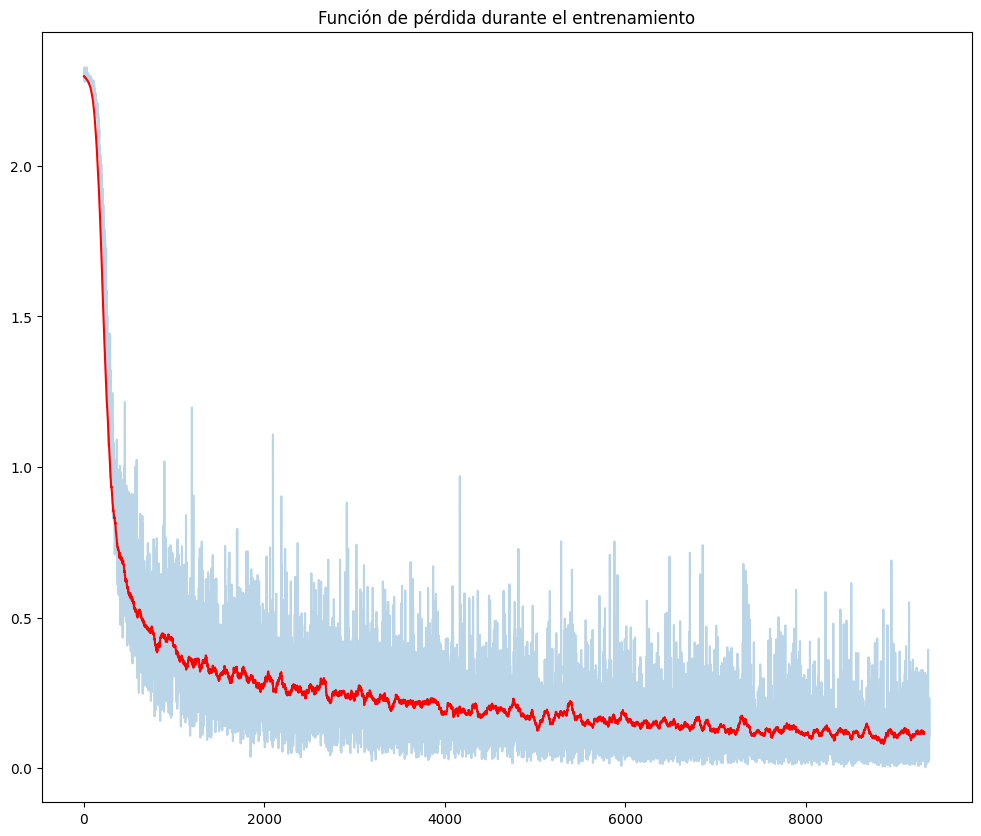

In [ ]:
# Tamaño del batch de entrenamiento
batch_size = 50

# Tasa de aprendizaje inicial para el gradiente descendente
learning_rate = 0.0001

# Dispositivo en que se ejecturá el modelo: 'cuda:0' para GPU y 'cpu' para CPU
device = torch.device('cuda:0')

net = NetCNN()
net.to(device)

# Construimos el optimizador, y le indicamos que los parámetros a optimizar
# son los del modelo definido: net.parameters()

optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# Definimos también la función de pérdida a utilizar
criterion = torch.nn.CrossEntropyLoss()

# Creamos un loader iterable indicandole que debe leer los datos a partir de
# del dataset creado en el paso anterior. Este objeto puede ser iterado
# y nos devuelve de a un batch (x, y).
loader = DataLoader(dataset=mnist_train, batch_size=32, shuffle=True)

# Número de épocas
num_epochs = 5

# Lista en la que iremos guardando el valor de la función de pérdida en cada
# etapa de entrenamiento
loss_list = []

# Bucle de entrenamiento
for i in range(num_epochs):

    # Itero sobre todos los batches del dataset
    for x, y in loader:
        # Seteo en cero los gradientes de los parámetros a optimizar
        optimizer.zero_grad()

        # Movemos los tensores a memoria de GPU
        x = x.to(device)
        y = y.to(device)

        # Realizo la pasada forward por la red
        loss = criterion(net(x), y)

        # Realizo la pasada backward por la red
        loss.backward()

        # Actualizo los pesos de la red con el optimizador
        optimizer.step()

        # Me guardo el valor actual de la función de pérdida para luego graficarlo
        loss_list.append(loss.data.item())

    # Muestro el valor de la función de pérdida cada 100 iteraciones
    #if i > 0 and i % 100 == 0:
    print('Epoch %d, loss = %g' % (i, loss))

# Muestro la lista que contiene los valores de la función de pérdida
# y una versión suavizada (rojo) para observar la tendencia
plt.figure()
loss_np_array = np.array(loss_list)
plt.plot(loss_np_array, alpha = 0.3)
N = 60
running_avg_loss = np.convolve(loss_np_array, np.ones((N,))/N, mode='valid')
plt.plot(running_avg_loss, color='red')
plt.title("Función de pérdida durante el entrenamiento")


### Guardo el modelo

In [ ]:
torch.save(net.state_dict(), "./cnn20.pth")

#### Cargamos el modelo y visualizamos los resultados en los datos de test

Para ello, utilizaremos los métodos `classification_report` y `confusion_matrix` de scikitlearn.

In [ ]:
# Cargamos el modelo (no es necesario si el modelo se encuentra en memoria)
net = NetCNN()
net.load_state_dict(torch.load("./cnn20.pth"))
net.to(device)

NetCNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.98      1135
           2       0.97      0.98      0.97      1032
           3       0.98      0.96      0.97      1010
           4       0.96      0.98      0.97       982
           5       0.96      0.98      0.97       892
           6       0.98      0.98      0.98       958
           7       0.97      0.95      0.96      1028
           8       0.97      0.96      0.96       974
           9       0.97      0.95      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



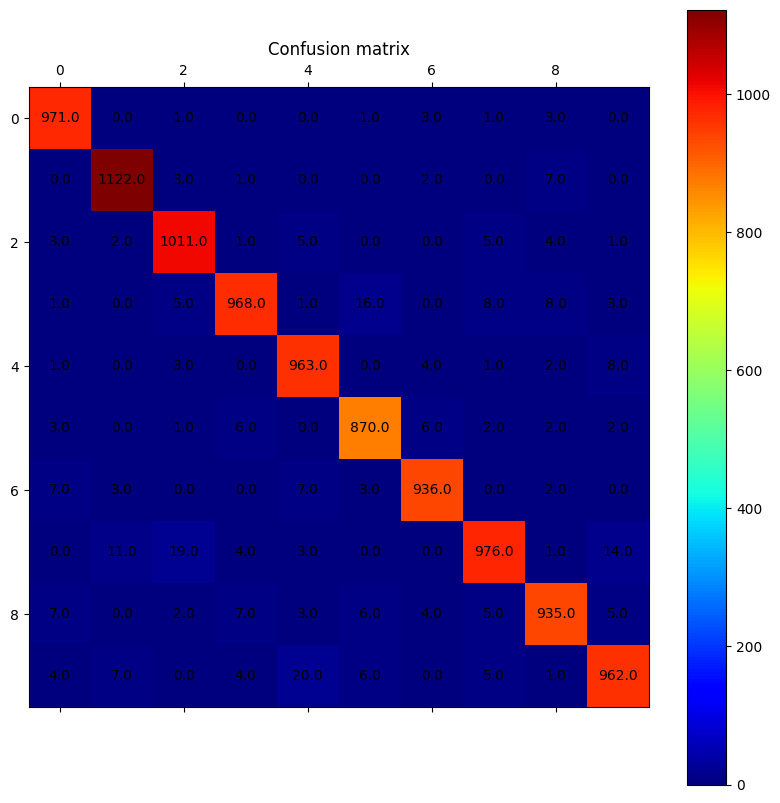

In [ ]:
# Mostramos los resultados
showTestResults(net)

# Entregable

1. Implementar el perceptrón multicapa y la red neuronal convolucional solicitadas.

2. Para el caso de la red neuronal convolucional, realizar el cálculo del tamaño de la entrada y salida en cada capa convolucional en función de los parámetros de cada capa (tamaño del kernel, padding, stride, etc) para garantizar que los tensores que fluyen por la red sean del tamaño adecuado. Indicar el tamaño de los feature maps a medida que fluyen por la red.

3. Comparar la accuracy obtenida por el perceptrón muticapa y la red neuronal convolucional.

### 1)

Implementado en las celdas anteriores

### 2)

Utilizamos la fórmula para el tamaño de la salida: $O = \frac{(W - F + 2P)}{S} + 1$

Con los parámetros:
* F: tamaño del filtro
* W: Tamaño del feature map de entrada
* P: Padding
* S: Stride

Sea $C_1$ la primera capa convolucional. Tenemos:
* $F_1$: 5 (Determinado arbitrariamente por nosotros)
* $W_1$: 28 (Pues la imágen es de 28x28)
* $P_1$: 0 (Valor por default)
* $S_1$: 1

Entonces $O_1 = \frac{(28 - 5 + 2*0)}{1} + 1 = 24$

El feature map de entrada es la imágen de 28x28 , la salida son 6 feature maps de 24x24. Pues usamos 6 kernels.

Sea $MP_1$ la primera capa de max pooling. Tenemos:
* $F_2$: 2
* $W_2$: 24 (Pues los feature maps de la capa anterior tienen dimension 24x24)
* $P_2$: 0 (Valor por default)
* $S_2$: 2

Entonces $O_2 = \frac{(24 - 2 + 2*0)}{2} + 1 = 12$

La entrada son 6 feature maps de 24x24, la salida son 6 feature maps de 12x12.

Sea $C_2$ la segunda capa convolucional. Tenemos:
* $F_3$: 5 (Determinado arbitrariamente por nosotros)
* $W_3$: 12 (Pues la dimensión de los feature maps de entrada es de 12x12)
* $P_3$: 0 (Valor por default)
* $S_3$: 1

Entonces $O_3= \frac{(12 - 5 + 2*0)}{1} + 1 = 8$

La entrada son 6 feature maps de 12x12, la salida son 16 feature maps de 8x8. Pues usamos 16 kernels.

Sea $MP_2$ la segunda capa de max pooling. Tenemos:
* $F_4$: 2
* $W_4$: 8 (Pues los feature maps de la capa anterior tienen dimension 8x8)
* $P_4$: 0 (Valor por default)
* $S_4$: 2

Entonces $O_4 = \frac{(8 - 2 + 2*0)}{2} + 1 = 4$

La entrada son 16 feature maps de 8x8, la salida son 16 feature maps de 4x4.

Finalmente, tenemos un tensor de dimensiones 16x4x4. Para poder trabajar con un perceptrón multicapa transformamos esto en un vector unidimensional de tamaño $16*4*4 = 256$. Entonces la cantidad de neuronas de entrada en la primera capa del perceptrón multicapa tendrá 256 neuronas.

### 3)

Observamos que se obtiene una accuracy mayor con la red neuronal convolucional (0.97) que con el perceptrón multicapa (0.91)